# Painter by Numbers - Overview

In [2]:
import sys
import json
import warnings

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

In [4]:
base_dir = '/data/painter-by-numbers'

solution_file = f'{base_dir}/meta/solution_painter.csv'
submission_info_file = f'{base_dir}/meta/submission_info.csv'
info_file = f'{base_dir}/meta/all_data_info.csv'
train_info_file = f'{base_dir}/meta/train_info.csv'

labels = ['different-artist', 'same-artist']

strategy = 'mean'

TOTAL_ANSWERS = 21916047
USED_ANSWERS = 1.0

info_features = 'artist_group artist_name style genre source date'.split()

## Setup

In [9]:
pd.set_option('display.max_rows', 512)

def as_percentage(df, values='values', reduce_op=np.sum):
    return df.assign(**{values: df[values] / reduce_op(df[values])})

## Dataset

### Reading Solution and Submission Info

In [5]:
from hashlib import md5

def load_info(all_info_path, train_info_path):
    info = pd.read_csv(all_info_path).rename(columns={'new_filename': 'filename', 'artist': 'artist_name'})
    train_info = (pd.read_csv(train_info_path)
                  .drop(columns='title style genre date'.split())
                  .rename(columns={'artist': 'artist_hash'})
                  .set_index('filename'))

    info = info.merge(train_info, on='filename', how='left')

    # Remove months, fic, circa and other textual
    # info from dates. Them cast them to float.
    info['date'] = (info.date
                    .str.lstrip(r'c\.|(January|February|March|April|May|September|October|November|December)\s')
                    .str.replace('fic', 'nan', regex=False)
                    .str.replace(r'^$', 'nan', regex=True)
                    .astype(float))

    # Clear artist name. 
    info['artist_name'] = info.artist_name.str.strip().astype('str')
    
    # Build artist-hash based on the artist name.
    # Some artist hashes are missing. We will fill them by hashing the artist name.
    codes = info[~info.artist_hash.isna()][['artist_name', 'artist_hash']].drop_duplicates()
    codes = dict(zip(codes.artist_name, codes.artist_hash))

    hashes = info.artist_hash.copy()
    new_hashes = info.artist_name.map(lambda n: codes.get(n, md5(n.encode()).hexdigest()))
    hashes[hashes.isna()] = new_hashes[hashes.isna()]
    info['artist_hash'] = hashes

    return info

info = load_info(info_file, train_info_file)
info.set_index('filename', inplace=True)

info.head()

,artist_name,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,artist_hash
filename,,,,,,,,,,,,
102257.jpg,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,5b39c876740bfc1cfaf544721c43cac3
75232.jpg,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,5b39c876740bfc1cfaf544721c43cac3
32145.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
20304.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
836.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3


In [10]:
# Fixes some of the artist names that incorrectly
# contain part of the painting name.
fixes = (
    ('Mirror of the Ages', 'Toyohara Chikanobu'),
    ('La Dame de Biarritz', 'Giovanni Boldini'),
    ('Nikolai Evreinov "Pro Scena Suo.."', 'Nikolai Evreinov'),
    ('Messolonghi Lagoon', 'Konstantinos Maleas'),
    ('Modality Series', 'Jock Macdonald'),
    ('Mon Tokyo', 'Kiyoshi Saito'),
    ('Monhegan', 'Robert Henri'),
    ('Moon', 'Nakagawa Soen'),
    ('Moonlight', 'Eugene Boudin'),
    ('Morgat', 'Maxime Maufra'),
    ('Morning', 'Koloman Moser'),
)

for a, b in fixes:
    info.loc[info.artist_name == a, 'artist_name'] = b

In [11]:
solution, submission = map(pd.read_csv, (solution_file, submission_info_file))
[f.set_index('index', inplace=True) for f in [solution, submission]]
solution = submission.join(solution)
del submission

solution.head()

,image1,image2,sameArtist
index,,,
0,100005.jpg,100004.jpg,0.0
1,100014.jpg,100004.jpg,0.0
2,100014.jpg,100005.jpg,0.0
3,100022.jpg,100004.jpg,0.0
4,100022.jpg,100005.jpg,0.0


In [12]:
info.head()

,artist_name,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,artist_hash
filename,,,,,,,,,,,,
102257.jpg,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,5b39c876740bfc1cfaf544721c43cac3
75232.jpg,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,5b39c876740bfc1cfaf544721c43cac3
32145.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
20304.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
836.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3


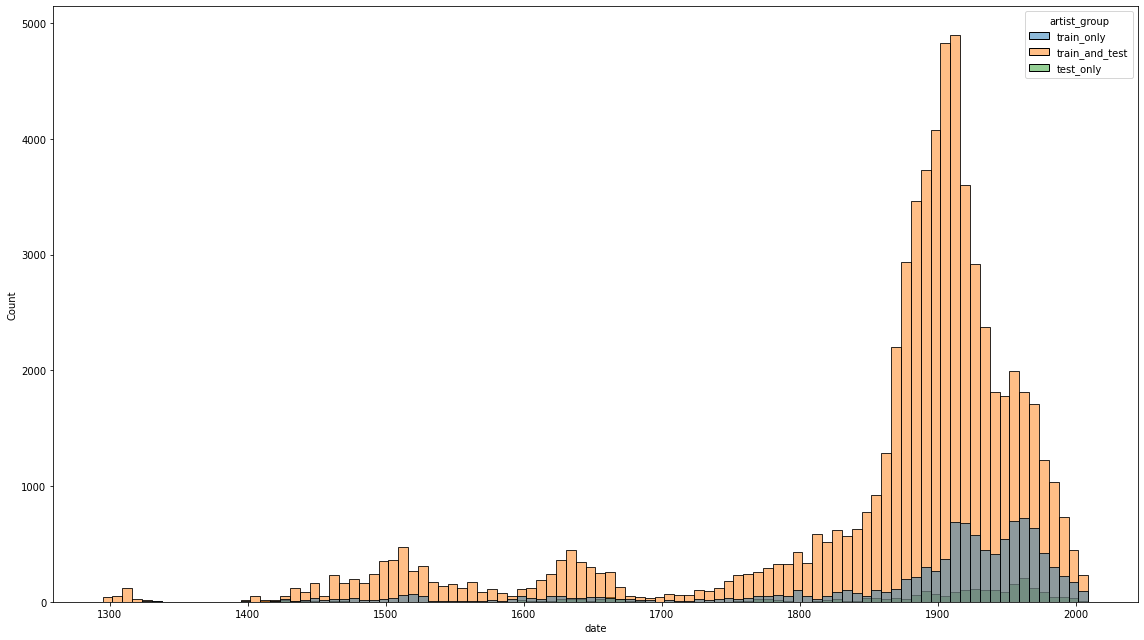

In [13]:
extremes = np.percentile(info.date[~info.date.isna()], [0.1, 99.9])
valids = (info.date > extremes[0]) & (info.date < extremes[1])

plt.figure(figsize=(16, 9))
sns.histplot(data=info[valids], x='date', hue='artist_group', bins=100)
plt.tight_layout();

In [14]:
info.head()

,artist_name,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,artist_hash
filename,,,,,,,,,,,,
102257.jpg,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,5b39c876740bfc1cfaf544721c43cac3
75232.jpg,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,5b39c876740bfc1cfaf544721c43cac3
32145.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
20304.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3
836.jpg,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,ba32cb06246fb28ec3404e93d0b270b3


In [60]:
stats = info.groupby(['artist_name'], as_index=False).agg({
    'artist_hash': 'count',
    'in_train': 'mean',
    'artist_group': 'first',
    'date': 'mean'
})

stats.columns = ['artist', 'paintings', 'in_train_rate', 'artist_group', 'date_avg']

stats.sort_values('paintings', ascending=False, inplace=True)

In [63]:
stats_recurrent = stats.head(100)
stats_recurrent.head().round(2)

,artist,paintings,in_train_rate,artist_group,date_avg
982,Ivan Shishkin,500,0.73,train_and_test,1881.08
102,Albrecht Durer,500,0.77,train_and_test,1506.69
1589,Pablo Picasso,500,0.75,train_and_test,1920.19
2205,Zdislav Beksinski,500,0.75,train_and_test,1981.86
832,Gustave Dore,500,0.77,train_and_test,1869.76


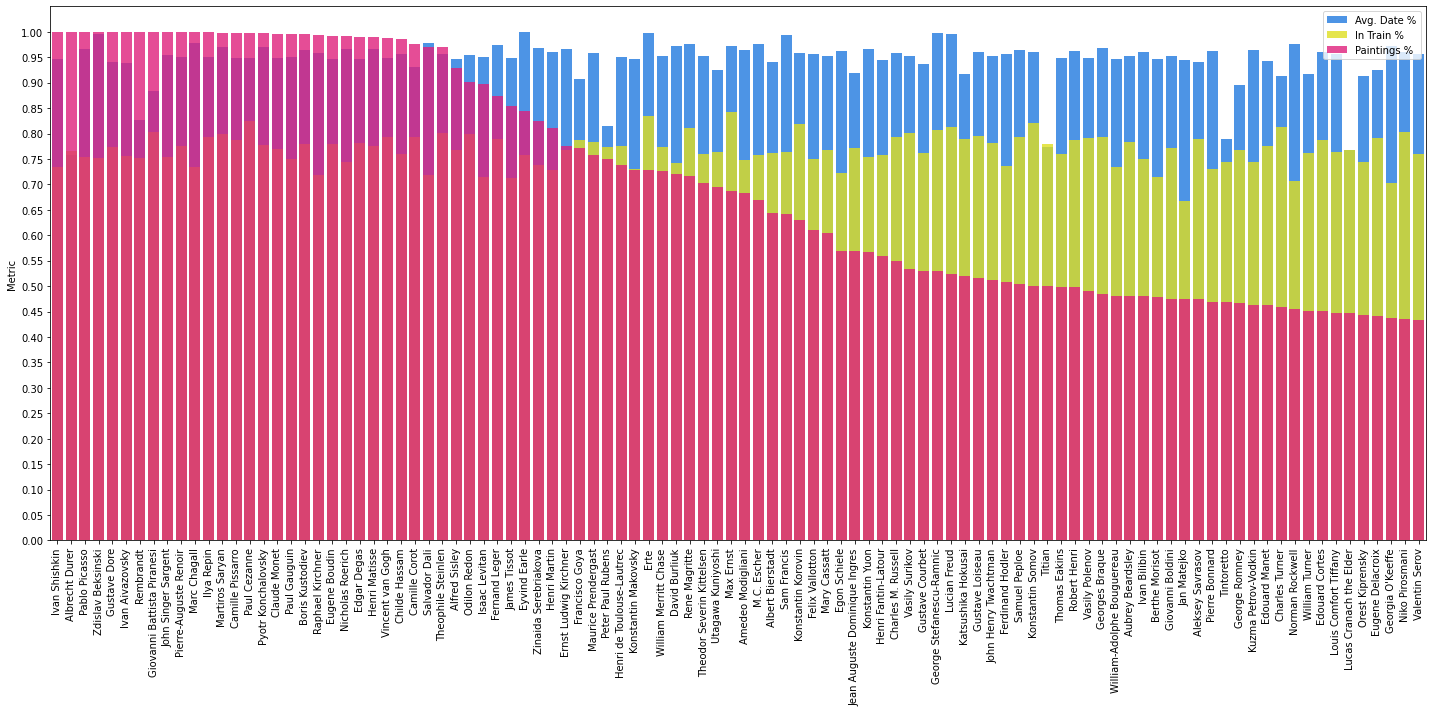

In [58]:
plt.figure(figsize=(20, 10))

sns.barplot(data=stats_recurrent.assign(date_rate=stats_recurrent.date_avg / stats_recurrent.date_avg.max()),
            x='artist', y='date_rate', label='Avg. Date %', color='#0077ff', alpha=.8)
sns.barplot(data=stats_recurrent,
            x='artist', y='in_train_rate', label='In Train %', color='yellow', alpha=.8)
sns.barplot(data=stats_recurrent.assign(paintings_rate=stats_recurrent.paintings / stats_recurrent.paintings.max()),
            x='artist', y='paintings_rate', label='Paintings %', color='#ff007b', alpha=.8)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.05))
plt.xlabel(None)
plt.ylabel('Metric')
plt.legend()
plt.tight_layout();